# Setup

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D, MaxPooling1D, Conv1D, Flatten
from tensorflow.keras.layers import Dense, SimpleRNN, Bidirectional, LSTM, GRU, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [2]:
def read_tweet(filepath):    
    tweets = []
    
    with open(filepath, "r") as f:
        for tweet in f:
            tweets.append(tweet.replace("\n", ""))
    
    return pd.Series(tweets)

def read_embedding(embedding_path):    
    vocab = []
    vectors = []
    
    with open(embedding_path, "r") as f:
        for line in f:
            word, coefs = line.split(maxsplit = 1)
            vectors.append(coefs.replace("\n", "").split(sep = " "))
            vocab.append(word)
    
    return vocab, np.array(vectors).astype(float)


In [3]:
def get_preprocessor(vocab, vectors, seq_length):    
    assert len(vocab) == len(vectors)
    vocab_size  = len(vocab)
    vector_size = len(vectors[0])
    
    vectorizer = TextVectorization(output_sequence_length = seq_length,
                                   output_mode = 'int',
                                   vocabulary  = vocab)
    
    embedding_weights = tf.keras.initializers.Constant(np.concatenate([
        np.zeros((2, vector_size)), # for padding and oov
        vectors
    ]))
    
    embedding = Embedding(vocab_size + 2, # for padding and oov
                          vector_size,
                          trainable  = False,
                          input_shape = (seq_length,),
                          embeddings_initializer = embedding_weights)

    return vectorizer, embedding 

In [17]:
def plot_history(history, metric, title = None):
    if title is None: title = metric.upper()
    epochs = len(history[metric])

    plt.plot(range(epochs), history[metric], label = "training loss")
    
    if "val_" + metric in history.keys():
        plt.plot(range(epochs), history["val_" + metric], label = "validation " + metric)
        plt.legend()
    
    plt.title(title)
    plt.show()

In [5]:
PATH_TWEETS = "./data/preprocessed/train/3-clean-nostw-lemma-negat.txt"
PATH_TARGETS = "./data/preprocessed/train/0-targets.txt"
PATH_EMBEDDING = "./data/embeddings/nn-3-clean-nostw-lemma-negat.txt"

SEQ_LENGTH = 100

OPTIMIZER = Adam(learning_rate = 0.0005)
REGULARIZER = "l2"
LOSS = "BinaryCrossentropy"
METRICS = ["accuracy"]

In [6]:
vocab, vectors = read_embedding(PATH_EMBEDDING)
vectorizer, embedding = get_preprocessor(vocab, vectors, SEQ_LENGTH)

In [7]:
X = read_tweet(PATH_TWEETS)
y = read_tweet(PATH_TARGETS)

In [8]:
X = vectorizer(X)
y = label_encoder.fit_transform(y)

# Model Alternatives

## Model 1 - NN

In [9]:
def get_model_nn_1(embedding_layer):
    model = Sequential([
            embedding_layer,
            GlobalAveragePooling1D(),
            Dense(32, activation='relu', kernel_regularizer = REGULARIZER),
            Dropout(0.5),
            Dense(64, activation='relu', kernel_regularizer = REGULARIZER),
            Dropout(0.5),
            Dense(32, activation='relu', kernel_regularizer = REGULARIZER),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)
    
    return model

In [10]:
tf.keras.backend.clear_session()
model = get_model_nn_1(embedding)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          7500600   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                9632      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [11]:
history = model.fit(X, y, epochs = 30, validation_split = 0.2)
history = history.history

Epoch 1/30
3921/3921 [==============================] - 18s 4ms/step - loss: 0.6074 - accuracy: 0.7720 - val_loss: 0.5003 - val_accuracy: 0.7975
Epoch 2/30
3921/3921 [==============================] - 18s 5ms/step - loss: 0.5289 - accuracy: 0.7782 - val_loss: 0.4911 - val_accuracy: 0.7973
Epoch 3/30
3921/3921 [==============================] - 19s 5ms/step - loss: 0.5191 - accuracy: 0.7808 - val_loss: 0.4843 - val_accuracy: 0.7956
Epoch 4/30
3921/3921 [==============================] - 18s 5ms/step - loss: 0.5144 - accuracy: 0.7803 - val_loss: 0.4796 - val_accuracy: 0.7971
Epoch 5/30
3921/3921 [==============================] - 16s 4ms/step - loss: 0.5097 - accuracy: 0.7825 - val_loss: 0.4800 - val_accuracy: 0.7934
Epoch 6/30
3921/3921 [==============================] - 17s 4ms/step - loss: 0.5076 - accuracy: 0.7828 - val_loss: 0.4752 - val_accuracy: 0.7952
Epoch 7/30
3921/3921 [==============================] - 18s 5ms/step - loss: 0.5033 - accuracy: 0.7841 - val_loss: 0.4734 - val_ac

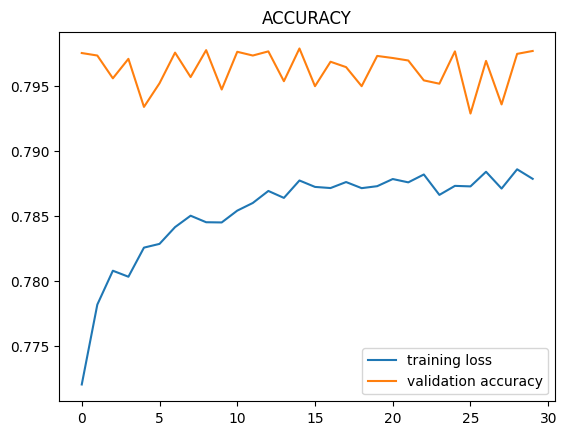

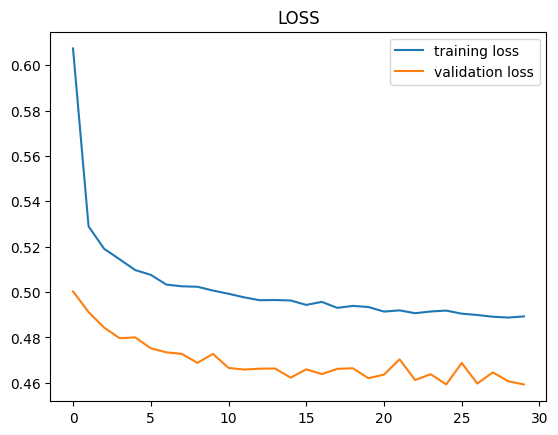

In [18]:
plot_history(history, "accuracy")
plot_history(history, "loss")

## Model 2 - NN with Convolutional Layer

In [13]:
def get_model_nn_2(embedding_layer):
    model = Sequential([
            embedding_layer,
            Conv1D(filters = 64, kernel_size = 3, activation = "relu"),
            MaxPooling1D(pool_size = 2),
            Dropout(0.5),
            Conv1D(filters = 128, kernel_size = 3, activation = "relu"),
            MaxPooling1D(pool_size = 2),
            Dropout(0.5),
            Conv1D(filters = 216, kernel_size = 3, activation = "relu"),
            MaxPooling1D(pool_size = 2),
            Dropout(0.5),
            Flatten(),
            Dense(512, activation='relu', kernel_regularizer = REGULARIZER),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)
    
    return model

In [14]:
tf.keras.backend.clear_session()
model = get_model_nn_2(embedding)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          7500600   
                                                                 
 conv1d (Conv1D)             (None, 98, 64)            57664     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 49, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 23, 128)          0         
 1D)                                                    

In [15]:
model.fit(X, y, epochs = 30, validation_split = 0.2)

Epoch 1/30
3921/3921 [==============================] - 25s 5ms/step - loss: 0.5263 - accuracy: 0.7800 - val_loss: 0.4909 - val_accuracy: 0.7815
Epoch 2/30
3921/3921 [==============================] - 21s 5ms/step - loss: 0.4804 - accuracy: 0.7850 - val_loss: 0.4704 - val_accuracy: 0.7868
Epoch 3/30
3921/3921 [==============================] - 22s 6ms/step - loss: 0.4781 - accuracy: 0.7866 - val_loss: 0.4815 - val_accuracy: 0.7888
Epoch 4/30
3921/3921 [==============================] - 22s 6ms/step - loss: 0.4765 - accuracy: 0.7871 - val_loss: 0.4818 - val_accuracy: 0.7854
Epoch 5/30
3921/3921 [==============================] - 21s 5ms/step - loss: 0.4757 - accuracy: 0.7875 - val_loss: 0.4630 - val_accuracy: 0.7902
Epoch 6/30
3921/3921 [==============================] - 22s 6ms/step - loss: 0.4750 - accuracy: 0.7870 - val_loss: 0.4693 - val_accuracy: 0.7871
Epoch 7/30
3921/3921 [==============================] - 21s 5ms/step - loss: 0.4752 - accuracy: 0.7883 - val_loss: 0.4759 - val_ac

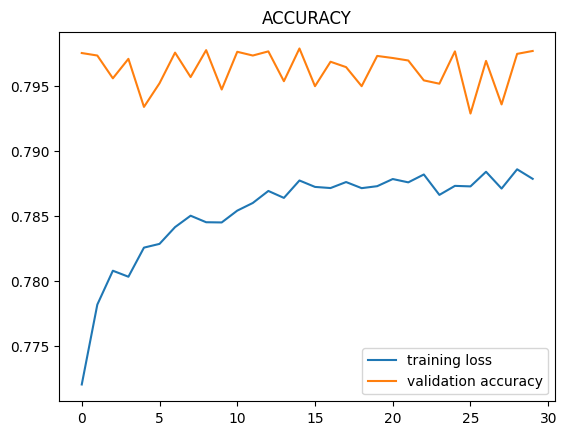

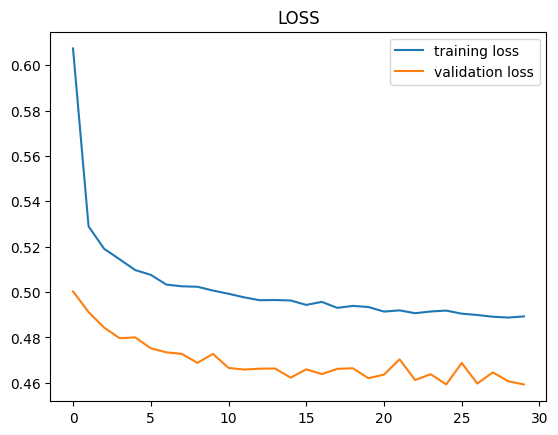

In [19]:
plot_history(history, "accuracy")
plot_history(history, "loss")

## Model 3 - Recurrent Neural Network

In [ ]:
def get_model_nn_3(embedding_layer):
    model = Sequential([
            embedding_layer,
            SimpleRNN(32, activation = "relu", 
                      kernel_regularizer = REGULARIZER, 
                      recurrent_regularizer = REGULARIZER,
                      return_sequences = True),
            SimpleRNN(32, activation = "relu", 
                      kernel_regularizer = REGULARIZER, 
                      recurrent_regularizer = REGULARIZER),
            Dropout(0.5),
            Dense(216, activation='relu', kernel_regularizer = REGULARIZER),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)
    
    return model

In [ ]:
tf.keras.backend.clear_session()
model = get_model_nn_3(embedding)
model.summary()

In [ ]:
model.fit(X, y, epochs = 15, validation_split = 0.2)

## Model 4 - RNN with GRU

In [ ]:
def get_model_nn_4(embedding_layer):
    model = Sequential([
            embedding_layer,
            GRU(32, activation = "relu", 
                kernel_regularizer = REGULARIZER, 
                recurrent_regularizer = REGULARIZER,
                return_sequences = True),
            GRU(32, activation = "relu", 
                kernel_regularizer = REGULARIZER, 
                recurrent_regularizer = REGULARIZER),
            Dropout(0.5),
            Dense(216, activation='relu', kernel_regularizer = REGULARIZER),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)
    
    return model

In [ ]:
tf.keras.backend.clear_session()
model = get_model_nn_4(embedding)
model.summary()

In [ ]:
model.fit(X, y, epochs = 15, validation_split = 0.2)

## Model 5 - RNN with LSTM

In [ ]:
def get_model_nn_5(embedding_layer):
    model = Sequential([
            embedding_layer,
            LSTM(32, activation = "relu", 
                 kernel_regularizer = REGULARIZER, 
                 recurrent_regularizer = REGULARIZER,
                 return_sequences = True),
            LSTM(32, activation = "relu", 
                 kernel_regularizer = REGULARIZER, 
                 recurrent_regularizer = REGULARIZER),
            Dropout(0.5),
            Dense(216, activation='relu', kernel_regularizer = REGULARIZER),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)
    
    return model

In [ ]:
tf.keras.backend.clear_session()
model = get_model_nn_5(embedding)
model.summary()

In [ ]:
model.fit(X, y, epochs = 15, validation_split = 0.2)